In [1]:
import scdrs

from scipy import stats
import pandas as pd
import scanpy as sc
from anndata import AnnData

sc.set_figure_params(dpi=125)

import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotnine

import warnings


In [2]:
# load adata
adata = sc.read_h5ad("../TC_LMMP.h5ad")

# subset gene sets
df_gs = pd.read_csv("./magma_10kb_1000.74_traits.gs", sep="\t", index_col=0)


In [3]:
covar = adata.obs[["batch", "num_genes_expressed"]]
covar.to_csv("lmmp_covar.tsv", sep = "\t")


In [4]:
adata

AnnData object with n_obs × n_vars = 35657 × 55385
    obs: 'sample', 'batch', 'age', 'cluster', 'Total_UMIs', 'log10UMI', 'num_genes_expressed', 'mito_ratio', 'cycle_phase', 'cycle_G1_score', 'cycle_G2M_score', 'cycle_S_score'
    var: 'gene_id_trimmed', 'gene_id', 'num_cells_expressed', 'gene_short_name'
    obsm: 'X_pca', 'X_umap', 'X_aligned'

Calling scDRS from within python runs, completes in 4 seconds and doesn't output any errors (or results). So call from command line

In [5]:
# %%capture

# !python ~/bin/scDRS/compute_score.py \
#     --h5ad_file ../TC_LMMP.h5ad \
#     --h5ad_species mouse \
#     --gs_file data/geneset.gs \
#     --cov_file lmmp_covar.tsv \
#     --gs_species mouse \
#     --flag_filter False \
#     --flag_raw_count False \
#     --flag_return_ctrl_raw_score False \
#     --flag_return_ctrl_norm_score True \
#     --out_folder data/

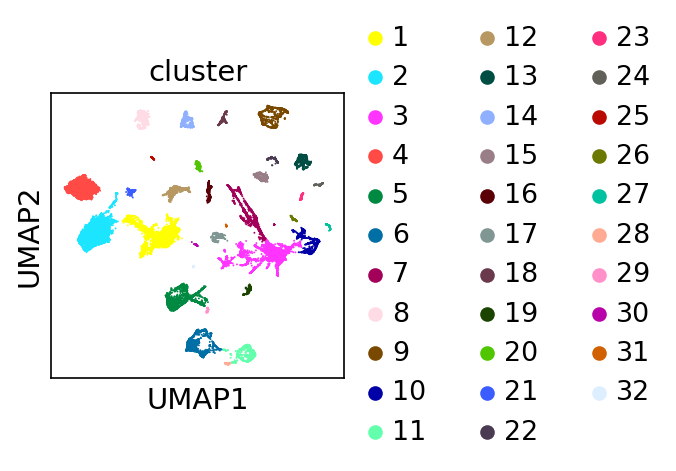

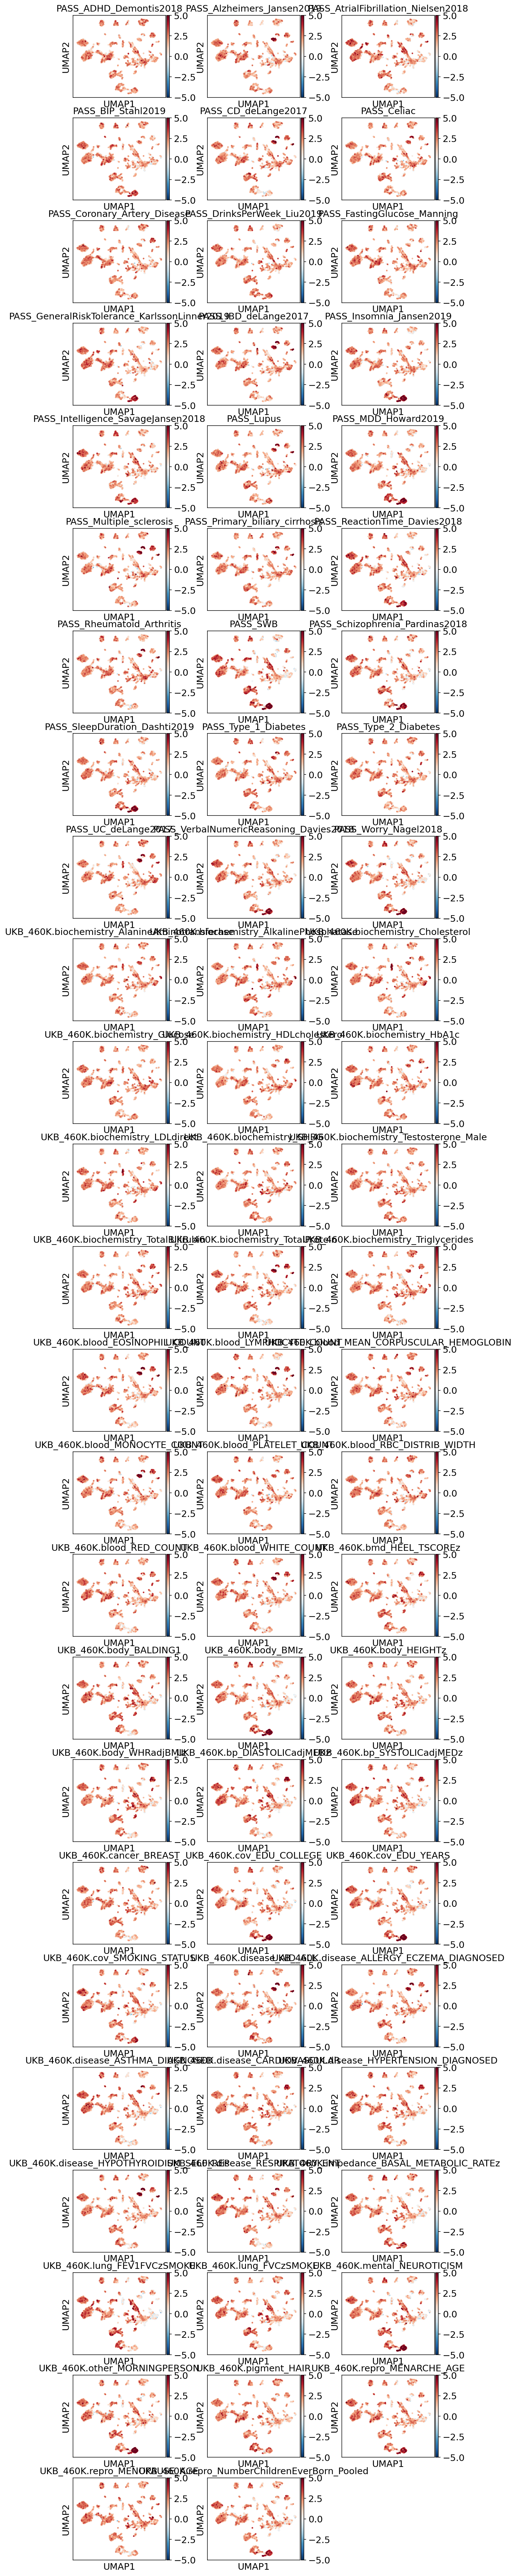

In [6]:
dict_score = {
    trait: pd.read_csv(f"out/{trait}.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}

for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

sc.set_figure_params(figsize=[2.5, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color="cluster",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,  
    ncols = 3,
)

In [11]:
#concatenate dictionary of data frame to multi-indexed df
df = pd.concat(dict_score, axis = 0)

#store top level index, which is the phenotype, and add to column for ggplot
phenotypes = df.index.droplevel(1)
df["phenotypes"] = phenotypes

#then drop multi-index, now indexes are cell ID
df.index = df.index.droplevel(0)

In [52]:
df.head()

adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 35657 × 55385
    obs: 'sample', 'batch', 'age', 'cluster', 'Total_UMIs', 'log10UMI', 'num_genes_expressed', 'mito_ratio', 'cycle_phase', 'cycle_G1_score', 'cycle_G2M_score', 'cycle_S_score', 'PASS_ADHD_Demontis2018', 'PASS_Alzheimers_Jansen2019', 'PASS_AtrialFibrillation_Nielsen2018', 'PASS_BIP_Stahl2019', 'PASS_CD_deLange2017', 'PASS_Celiac', 'PASS_Coronary_Artery_Disease', 'PASS_DrinksPerWeek_Liu2019', 'PASS_FastingGlucose_Manning', 'PASS_GeneralRiskTolerance_KarlssonLinner2019', 'PASS_IBD_deLange2017', 'PASS_Insomnia_Jansen2019', 'PASS_Intelligence_SavageJansen2018', 'PASS_Lupus', 'PASS_MDD_Howard2019', 'PASS_Multiple_sclerosis', 'PASS_Primary_biliary_cirrhosis', 'PASS_ReactionTime_Davies2018', 'PASS_Rheumatoid_Arthritis', 'PASS_SWB', 'PASS_Schizophrenia_Pardinas2018', 'PASS_SleepDuration_Dashti2019', 'PASS_Type_1_Diabetes', 'PASS_Type_2_Diabetes', 'PASS_UC_deLange2017', 'PASS_VerbalNumericReasoning_Davies2018',

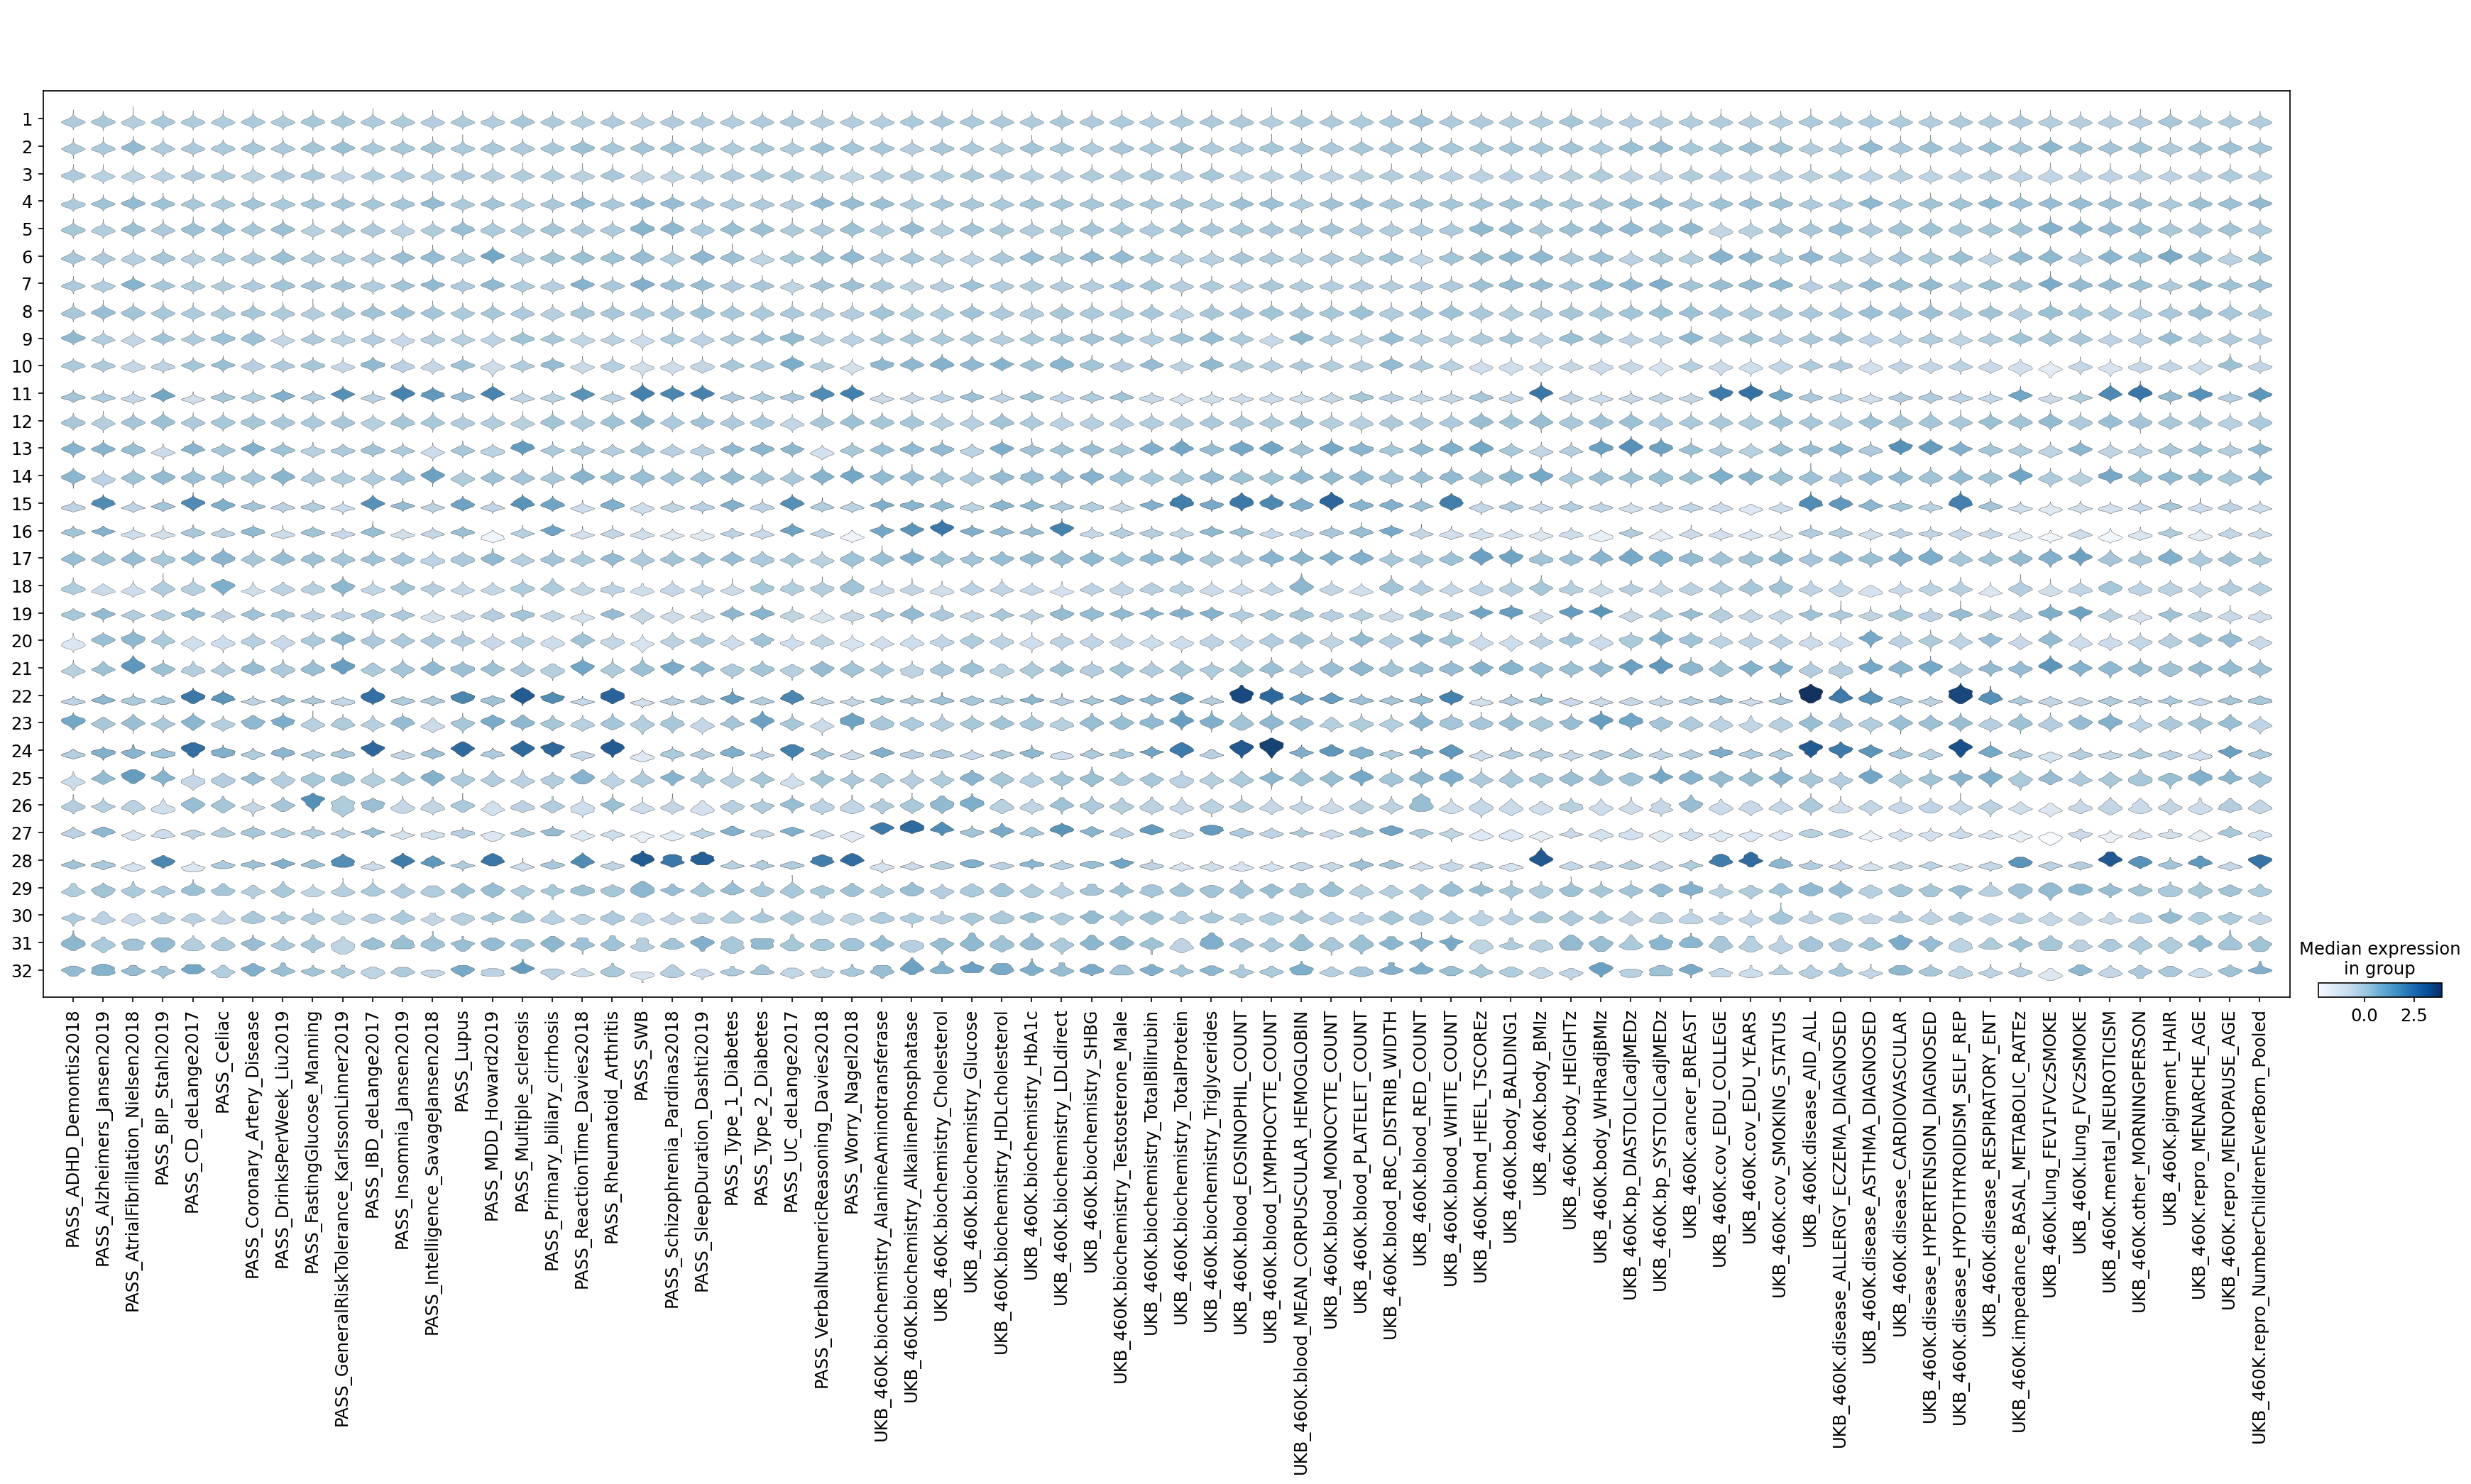

In [70]:

phenotypes_uniq = np.unique(phenotypes.values)

sc.pl.stacked_violin(adata, list(phenotypes_uniq), groupby = "cluster")



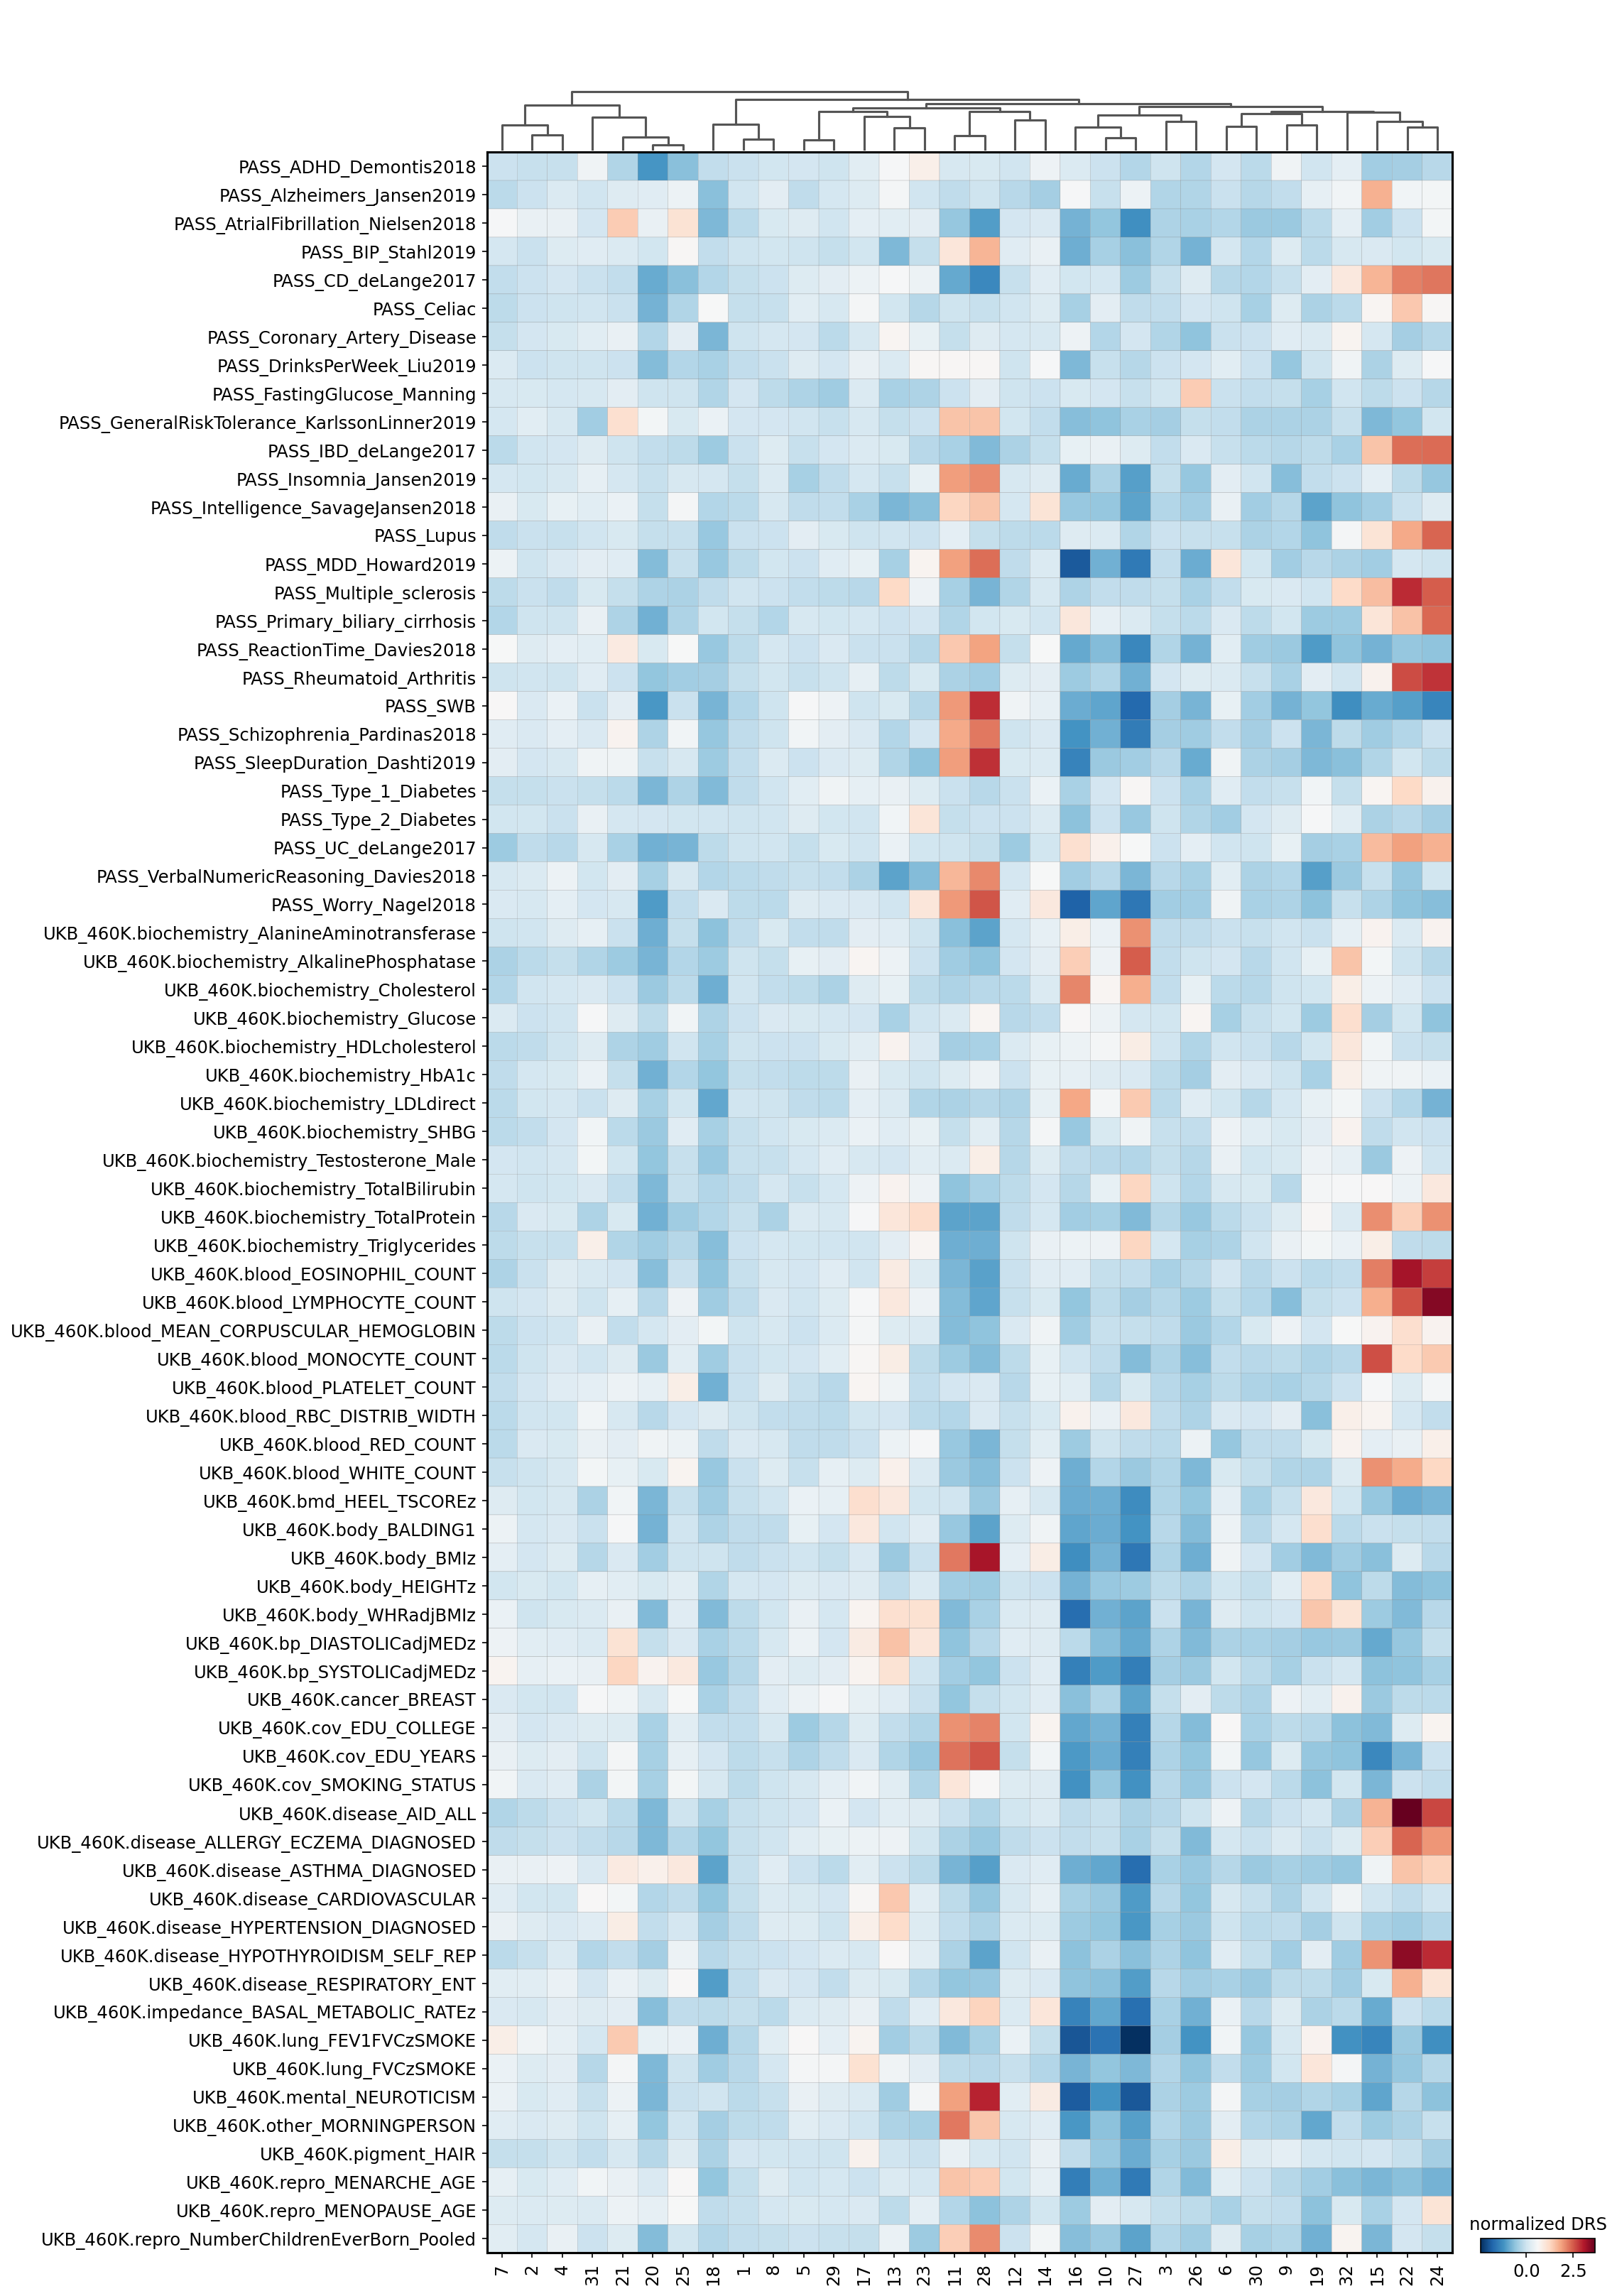

In [74]:
sc.pl.matrixplot(adata, list(phenotypes_uniq), 'cluster', colorbar_title = "normalized DRS", swap_axes = True, dendrogram=True, cmap='RdBu_r')